<a href="https://colab.research.google.com/github/Astrocitos/A017930806.2/blob/main/Ensemble__SVC_RF_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ensamblado

##Instalación de librerías

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc, ConfusionMatrixDisplay, matthews_corrcoef, fbeta_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tqdm import tqdm
import time
from joblib import Parallel, delayed, dump, load
import shap
from scipy.stats import uniform, randint

Aquí se incluyen las herramientas para hacer preprocesamiento de datos, reduccion de dimensiones, modelado, evaluación de los modelos y visualización

##Preprocesamiento

In [ ]:
# Cargar y preprocesar datos
def load_and_preprocess_data(file_path):
    df = pd.read_parquet(file_path)
    # Codificar variables categóricas
    encoder = OrdinalEncoder()
    df_encoded = df.copy()
    df_encoded[df.select_dtypes(include=['object']).columns] = encoder.fit_transform(df.select_dtypes(include=['object']))
    # Separar características y variable objetivo
    X = df_encoded.drop(columns=['crcinfarto'])
    y = df_encoded['crcinfarto']
    # Escalar las características
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

##Reducción de la dimensionalidad

In [ ]:
# Aplicar PCA para reducción de dimensionalidad
def apply_pca(X, n_components=0.95):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

##Balanceo de Clases

In [ ]:
# Balancear clases y dividir los datos usando RandomUnderSampler
def balance_and_split_data(X, y):
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    return X_res, y_res

##Optimización de hiperparámetros

In [ ]:
# Búsqueda de hiperparámetros previa
def perform_random_search(X, y, n_iter=10):
    #Division de los datos en conjuntos de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    #Estimadores base
    estimators = [
        ('svc', SVC(kernel='rbf', probability=True)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ]
    #clasificador de ensamble stacking
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    #definir el espacio de busqueda para los hiperparametros
    param_distributions = {
        'svc__C': uniform(0.1, 10),
        'svc__gamma': uniform(0.01, 1),
        'rf__n_estimators': randint(50, 150),
        'rf__max_depth': [None, 10, 20],
        'xgb__n_estimators': randint(50, 150),
        'xgb__learning_rate': uniform(0.01, 0.1)
    }
    #Configuracion de RandomizedSearchCV
    random_search = RandomizedSearchCV(stacking_clf, param_distributions, n_iter=n_iter, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
    #ajustar el modelo en los datos de entrenamiento
    random_search.fit(X_train, y_train)
    #regresa los mejores parametros encontrados
    return random_search.best_params_

##Definición y entrenamiento del modelo

In [ ]:
# Usar los mejores hiperparámetros para entrenar el modelo
def define_and_train_stacking_with_best_params(X_train, y_train, best_params):
    estimators = [
        ('svc', SVC(kernel='rbf', probability=True, C=best_params['svc__C'], gamma=best_params['svc__gamma'])),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=best_params['rf__n_estimators'], max_depth=best_params['rf__max_depth'])),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=best_params['xgb__n_estimators'], learning_rate=best_params['xgb__learning_rate']))
    ]
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
    stacking_clf.fit(X_train, y_train)
    return stacking_clf

##Entrenamiento y evaluación de cada fold

In [ ]:
# Entrenar y evaluar un fold
def train_evaluate_fold(train_index, test_index, X, y, best_params):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    start_time = time.time()
    stacking_clf = define_and_train_stacking_with_best_params(X_train, y_train, best_params)
    training_time = time.time() - start_time

    y_train_pred = stacking_clf.predict(X_train)
    y_pred = stacking_clf.predict(X_test)
    y_prob = stacking_clf.predict_proba(X_test)[:, 1] * 100

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob / 100)
    mcc = matthews_corrcoef(y_test, y_pred)
    f2_score = fbeta_score(y_test, y_pred, beta=2)

    return stacking_clf, X_test, train_accuracy, test_accuracy, auc_score, mcc, f2_score, training_time, y_test, y_pred, y_prob

##Entrenamiento y Evaluación del modelo completo

In [ ]:
# Entrenar y evaluar el modelo en validación cruzada
def train_and_evaluate_model(X, y, n_splits=5, best_params=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    models = []

    with tqdm(total=n_splits, desc="Training Folds") as pbar:
        def delayed_evaluation(train_index, test_index):
            return train_evaluate_fold(train_index, test_index, X, y, best_params)

        results_and_models = Parallel(n_jobs=-1)(delayed(delayed_evaluation)(train_index, test_index) for train_index, test_index in skf.split(X, y))

        pbar.update(n_splits)

    for stacking_clf, X_test, train_acc, test_acc, auc, mcc, f2_score, t_time, y_test, y_pred, y_prob in results_and_models:
        models.append(stacking_clf)
        results.append((train_acc, test_acc, auc, mcc, f2_score, t_time, y_test, y_pred, y_prob))

    train_accuracies, test_accuracies, aucs, mccs, f2_scores, training_times, y_tests, y_preds, y_probs = zip(*results)

    # Visualización de resultados
    plot_training_progress(train_accuracies, test_accuracies, aucs, mccs, f2_scores)

    for fold, (train_acc, test_acc, auc, mcc, f2_score, t_time, y_test, y_pred, y_prob) in enumerate(results, 1):
        print(f"Fold {fold}:")
        print(f"Training Time: {t_time:.2f} seconds")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"AUC: {auc:.4f}")
        print(f"MCC: {mcc:.4f}")
        print(f"F2 Score: {f2_score:.4f}")
        print(f"Risk Percentages: {y_prob}\n")
        print_model_evaluation(stacking_clf, X_test, y_test, y_pred, y_prob)

    print(f"Mean Train Accuracy: {np.mean(train_accuracies):.4f}")
    print(f"Mean Test Accuracy: {np.mean(test_accuracies):.4f}")
    print(f"Mean AUC: {np.mean(aucs):.4f}")
    print(f"Mean MCC: {np.mean(mccs):.4f}")
    print(f"Mean F2 Score: {np.mean(f2_scores):.4f}")
    print(f"Total Training Time: {np.sum(training_times):.2f} seconds")

    return models, results

##Visualización del progreso de entrenamiento

In [ ]:
# Visualización del Progreso de Entrenamiento
def plot_training_progress(train_accuracies, test_accuracies, aucs, mccs, f2_scores):
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 2, 1)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Train Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Train Accuracy')
    plt.title('Training Accuracy per Fold')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', label='Test Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy per Fold')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(range(1, len(aucs) + 1), aucs, marker='o', label='AUC')
    plt.xlabel('Fold')
    plt.ylabel('AUC')
    plt.title('Training AUC per Fold')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(range(1, len(mccs) + 1), mccs, marker='o', label='MCC')
    plt.xlabel('Fold')
    plt.ylabel('MCC')
    plt.title('Training MCC per Fold')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(range(1, len(f2_scores) + 1), f2_scores, marker='o', label='F2 Score')
    plt.xlabel('Fold')
    plt.ylabel('F2 Score')
    plt.title('Training F2 Score per Fold')
    plt.legend()

    plt.tight_layout()
    plt.show()

##Evaluación del Modelo

In [ ]:
# Imprimir y visualizar las métricas de evaluación del modelo
def print_model_evaluation(stacking_clf, X_test, y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    report = classification_report(y_test, y_pred)
    print(f'Classification Report:\n{report}')

    fpr, tpr, _ = roc_curve(y_test, y_prob / 100)
    auc_score = roc_auc_score(y_test, y_prob / 100)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_prob / 100)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'PRC Curve (AUC = {prc_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Utilizar SHAP para interpretar los modelos base
    for name, model in stacking_clf.named_estimators_.items():
        print(f"Interpreting model: {name}")
        if isinstance(model, SVC):
            # Reducir el tamaño de la muestra para acelerar KernelExplainer
            sample = shap.sample(X_test, 10)
            explainer = shap.KernelExplainer(model.predict_proba, sample)
            shap_values = explainer.shap_values(X_test[:10])
            shap.summary_plot(shap_values, X_test[:10], plot_type="bar")
        else:
            explainer = shap.Explainer(model, X_test)
            shap_values = explainer(X_test)
            shap.summary_plot(shap_values, X_test)

Guardado y carga del modelo

In [ ]:
# Guardar el modelo entrenado y los mejores hiperparámetros
def save_model_and_params(model, best_params, model_path='model.joblib', params_path='best_params.joblib'):
    dump(model, model_path)
    dump(best_params, params_path)
    print(f"Modelo guardado en {model_path}")
    print(f"Hiperparámetros guardados en {params_path}")

In [ ]:
# Cargar el modelo y los mejores hiperparámetros
def load_model_and_params(model_path='model.joblib', params_path='best_params.joblib'):
    model = load(model_path)
    best_params = load(params_path)
    return model, best_params

##Ejecución principal

In [ ]:
# Ejecución
start_time = time.time()
data_path = 'MIDO_cleaned.parquet'

X, y = load_and_preprocess_data(data_path)
X_pca = apply_pca(X)
X_res, y_res = balance_and_split_data(X_pca, y)

# Realizar búsqueda de hiperparámetros
best_params = perform_random_search(X_res, y_res, n_iter=10)

Training Folds: 100%|██████████| 3/3 [00:39<00:00, 13.29s/it]


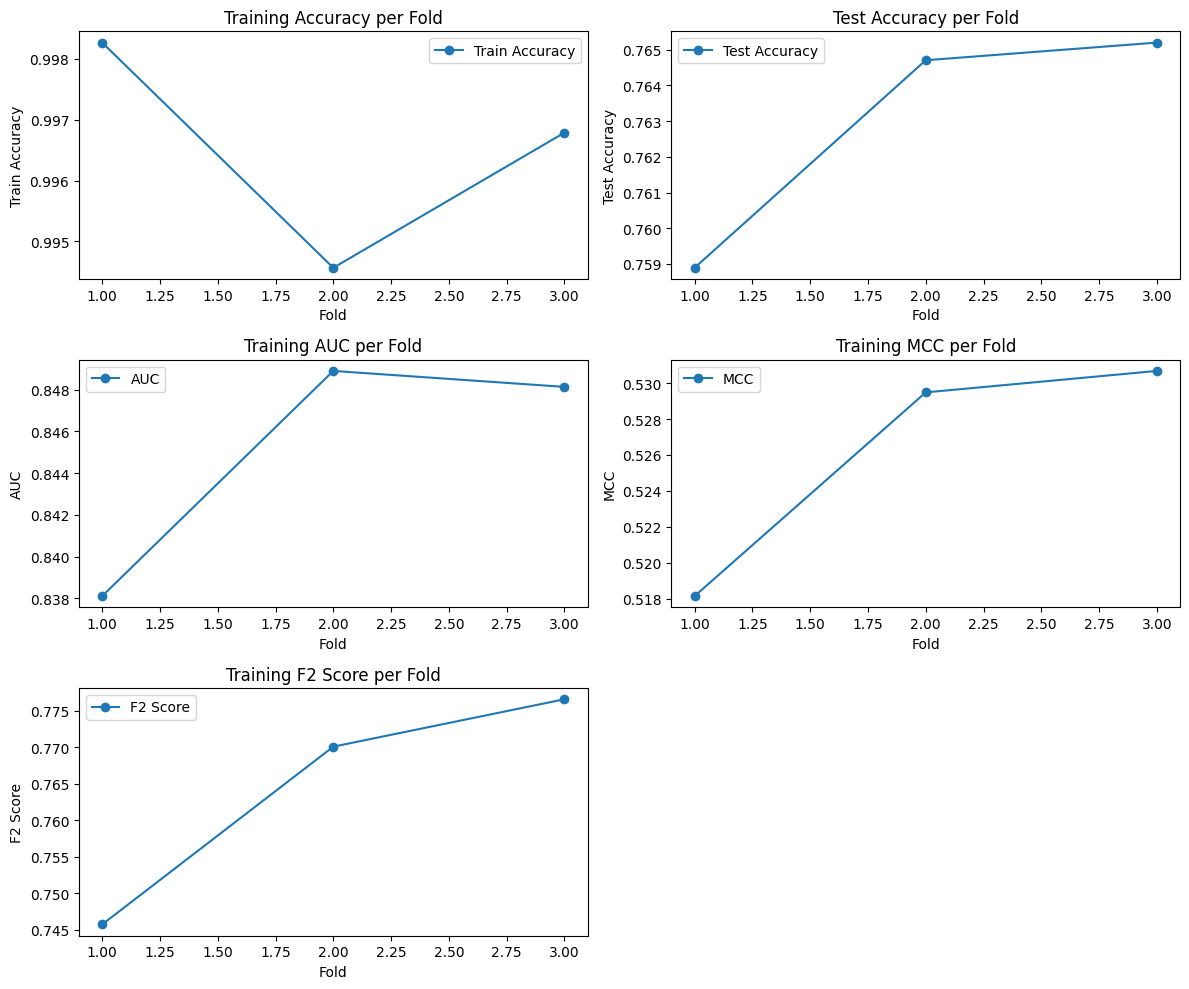

Fold 1:
Training Time: 37.21 seconds
Train Accuracy: 0.9983
Test Accuracy: 0.7589
AUC: 0.8381
MCC: 0.5182
F2 Score: 0.7457
Risk Percentages: [27.74023199 21.5232971   8.64790421 ... 87.49252325 46.6313732
 89.45086665]

Accuracy: 0.7589


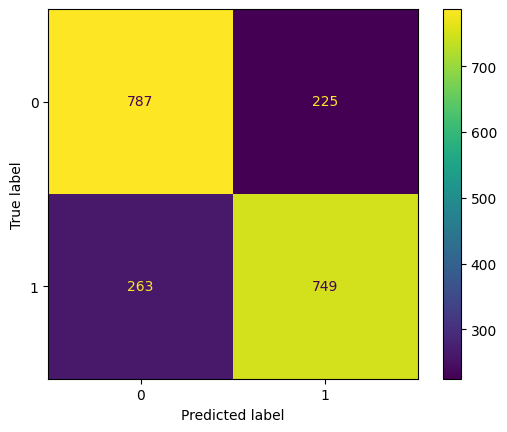

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1012
           1       0.77      0.74      0.75      1012

    accuracy                           0.76      2024
   macro avg       0.76      0.76      0.76      2024
weighted avg       0.76      0.76      0.76      2024



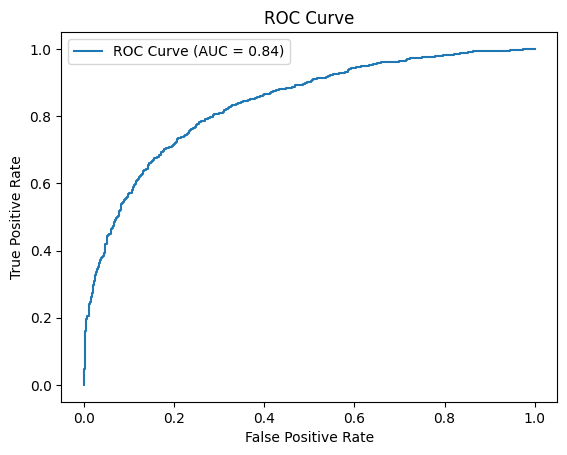

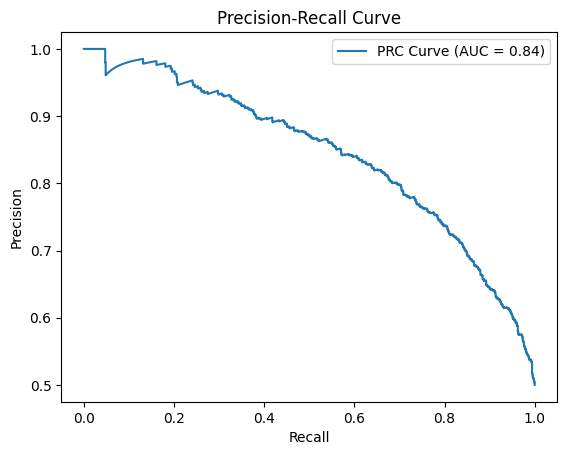

Interpreting model: svc


  0%|          | 0/10 [00:00<?, ?it/s]

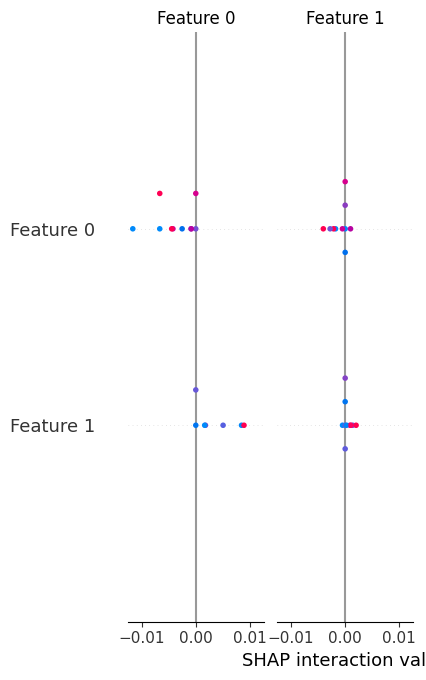

Interpreting model: rf


 99%|===================| 4022/4046 [02:03<00:00]       

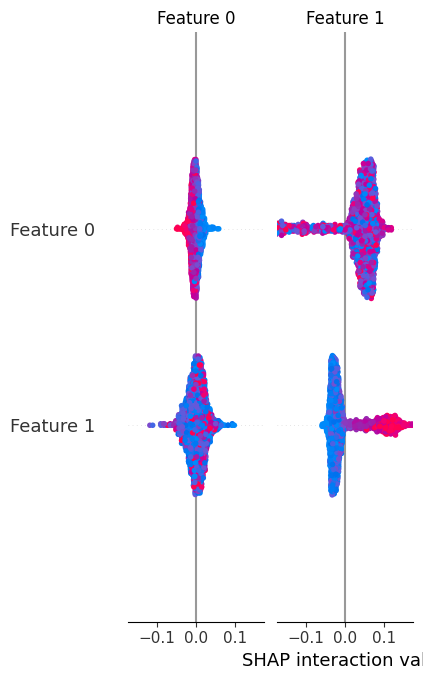

Interpreting model: xgb


 94%|=================== | 1901/2023 [00:11<00:00]       

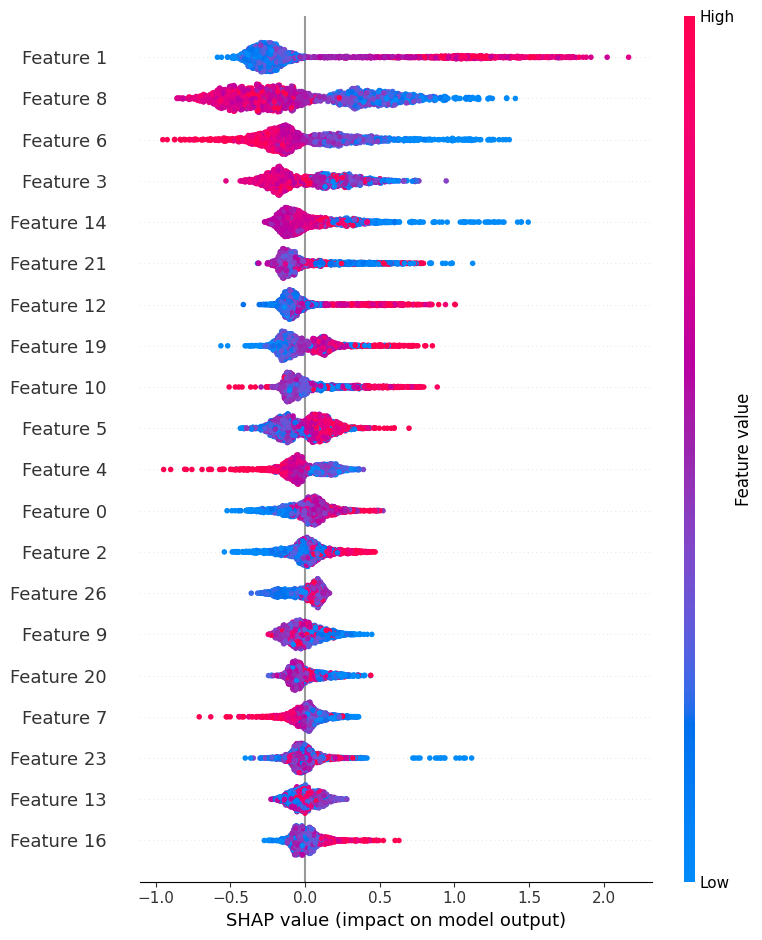

Fold 2:
Training Time: 37.43 seconds
Train Accuracy: 0.9946
Test Accuracy: 0.7647
AUC: 0.8489
MCC: 0.5295
F2 Score: 0.7701
Risk Percentages: [ 6.96185851 11.90263437 54.20672651 ... 40.08695608 87.60469126
 85.9526131 ]

Accuracy: 0.7647


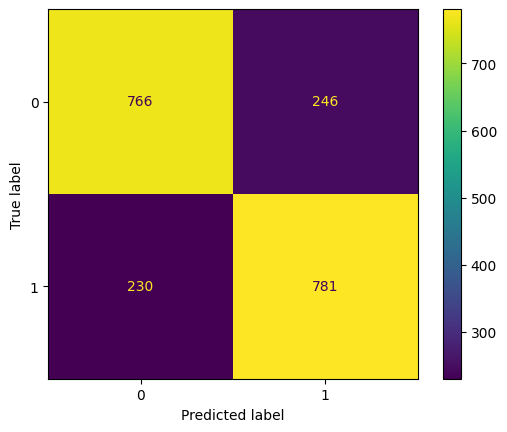

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1012
           1       0.76      0.77      0.77      1011

    accuracy                           0.76      2023
   macro avg       0.76      0.76      0.76      2023
weighted avg       0.76      0.76      0.76      2023



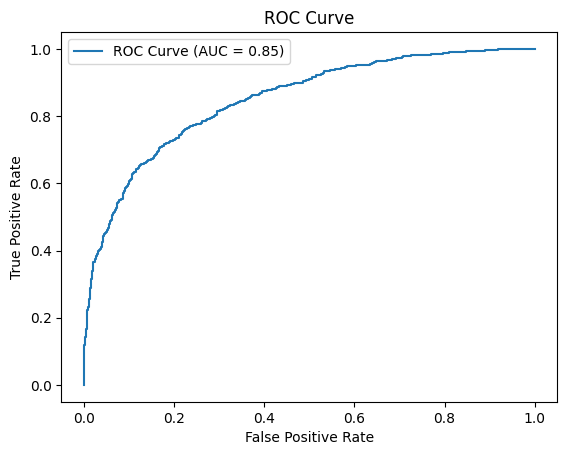

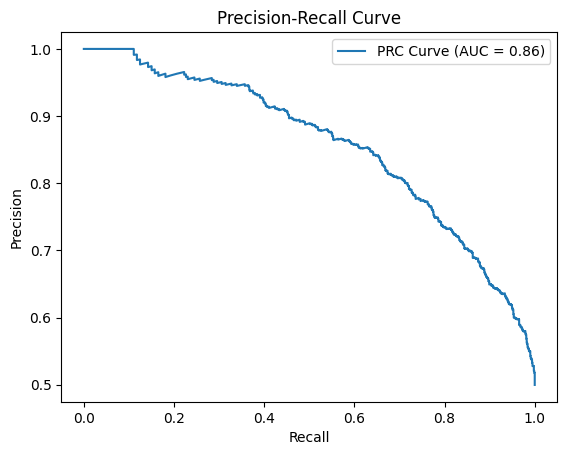

Interpreting model: svc


  0%|          | 0/10 [00:00<?, ?it/s]

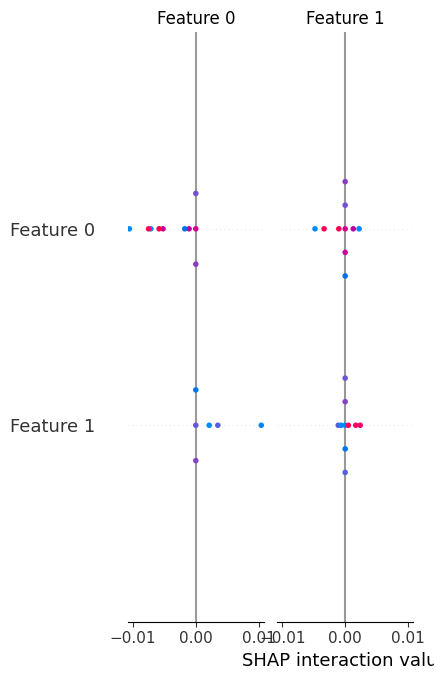

Interpreting model: rf


100%|===================| 4034/4046 [02:03<00:00]       

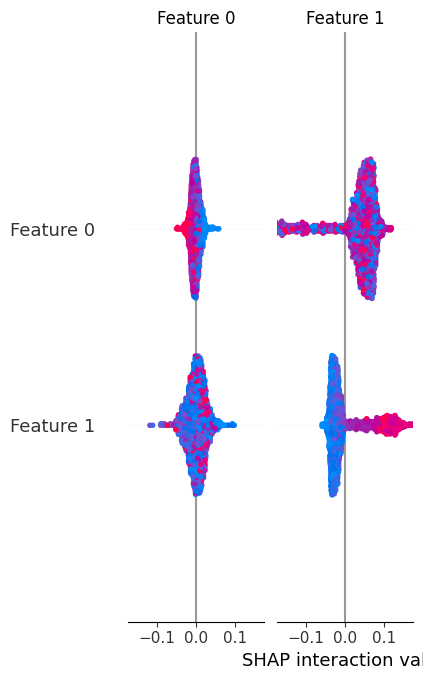

Interpreting model: xgb


 97%|=================== | 1964/2023 [00:12<00:00]       

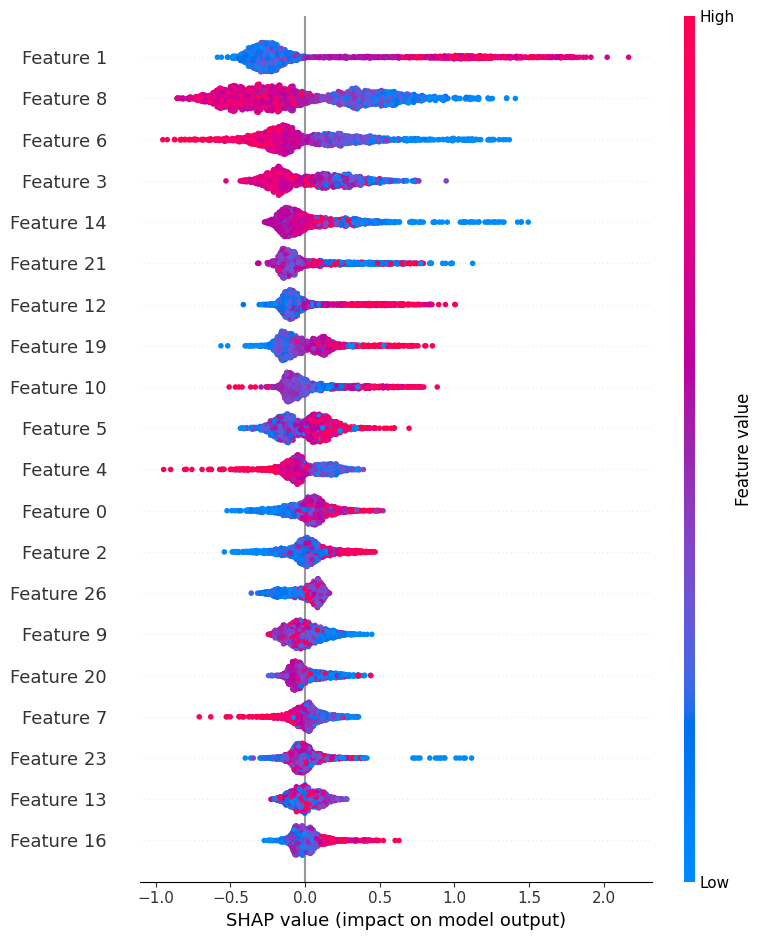

Fold 3:
Training Time: 37.21 seconds
Train Accuracy: 0.9968
Test Accuracy: 0.7652
AUC: 0.8481
MCC: 0.5307
F2 Score: 0.7766
Risk Percentages: [17.65870905 86.52664878 76.30007449 ... 69.91309394 87.93512077
 54.11120712]

Accuracy: 0.7652


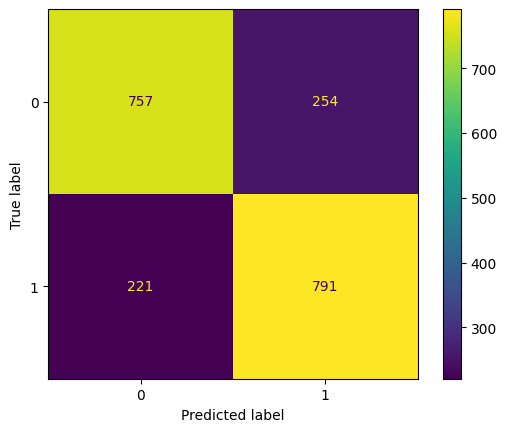

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1011
           1       0.76      0.78      0.77      1012

    accuracy                           0.77      2023
   macro avg       0.77      0.77      0.77      2023
weighted avg       0.77      0.77      0.77      2023



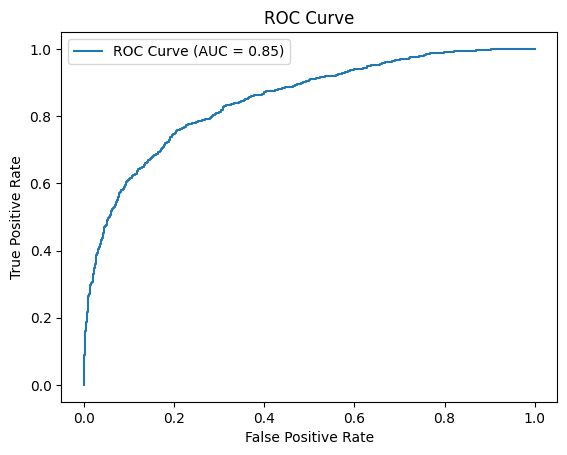

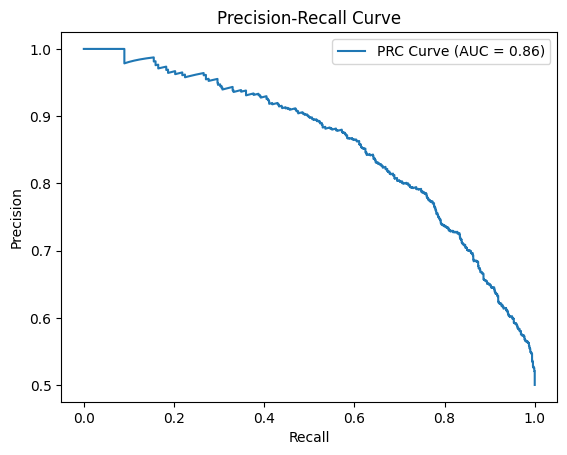

Interpreting model: svc


  0%|          | 0/10 [00:00<?, ?it/s]

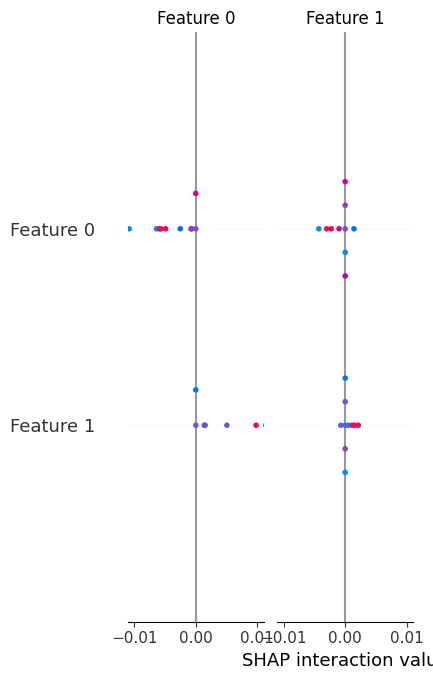

Interpreting model: rf


 99%|===================| 4021/4046 [02:03<00:00]       

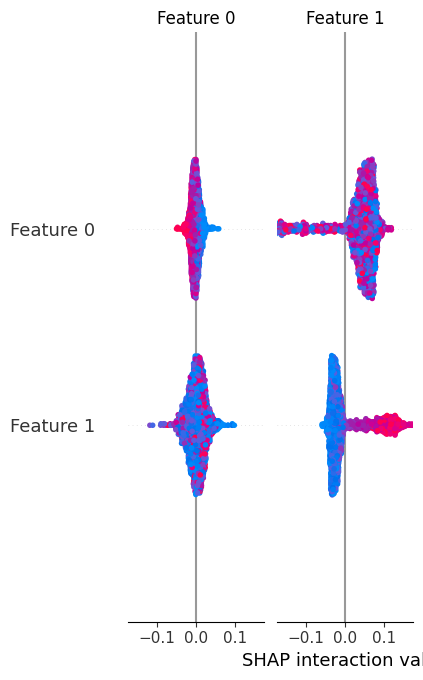

Interpreting model: xgb


 94%|=================== | 1901/2023 [00:11<00:00]       

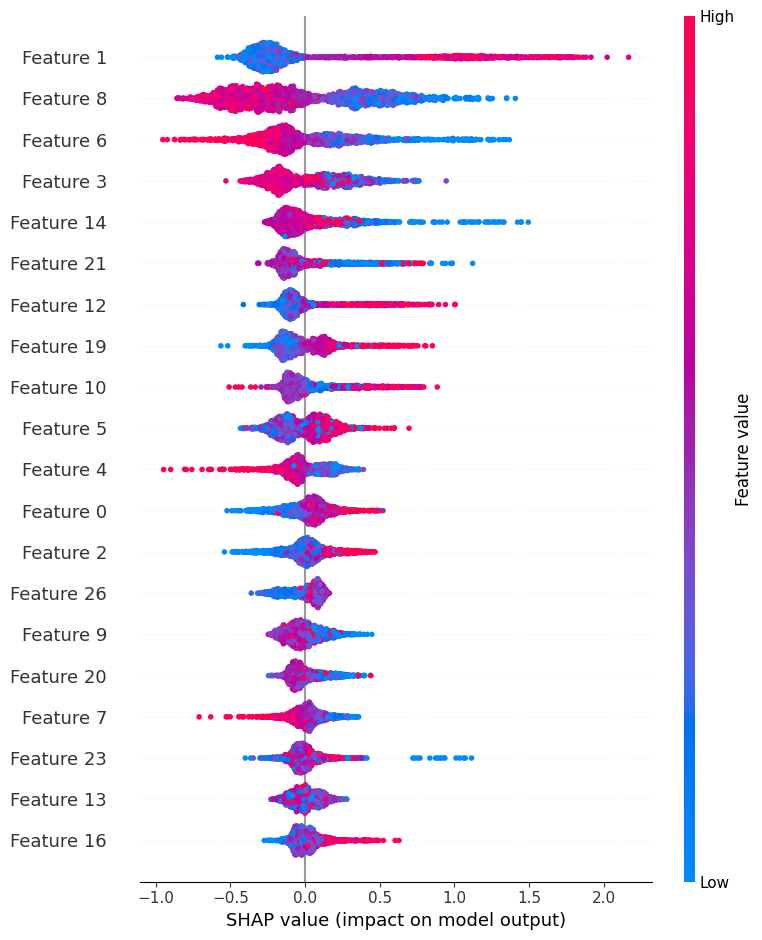

Mean Train Accuracy: 0.9965
Mean Test Accuracy: 0.7629
Mean AUC: 0.8450
Mean MCC: 0.5261
Mean F2 Score: 0.7641
Total Training Time: 111.85 seconds
Modelo guardado en model.joblib
Hiperparámetros guardados en best_params.joblib
Tiempo total de entrenamiento: 12.90 minutos


In [ ]:
# Ejecución del training
trained_model = train_and_evaluate_model(X_res, y_res, n_splits=3, best_params=best_params)

# Guardar el modelo entrenado y los mejores hiperparámetros
save_model_and_params(trained_model, best_params)

end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time / 60:.2f} minutos")

In [ ]:
file_path = 'MIDO_cleaned.parquet'
df = pd.read_parquet(file_path)

# Imprimir los nombres de las columnas
column_names = X.columns
print(column_names)

# Identificar las características específicas
feature_0_name = column_names[0]
feature_1_name = column_names[1]
feature_8_name = column_names[8]
feature_6_name = column_names[6]
feature_3_name = column_names[3]
feature_14_name = column_names[14]
feature_21_name = column_names[21]
feature_12_name = column_names[12]
feature_19_name = column_names[19]
feature_10_name = column_names[10]

print(f'Feature 0 corresponde a: {feature_0_name}')
print(f'Feature 1 corresponde a: {feature_1_name}')
print(f'Feature 8 corresponde a: {feature_8_name}')
print(f'Feature 6 corresponde a: {feature_6_name}')
print(f'Feature 3 corresponde a: {feature_3_name}')
print(f'Feature 14 corresponde a: {feature_14_name}')
print(f'Feature 21 corresponde a: {feature_21_name}')
print(f'Feature 12 corresponde a: {feature_12_name}')
print(f'Feature 19 corresponde a: {feature_19_name}')
print(f'Feature 10 corresponde a: {feature_10_name}')

Index(['edad', 'sexo', 'crcdiabetico', 'crglucosa_previa', 'crchipertenso',
       'cecpadresdm', 'cechermanosdm', 'crcfuma', 'crcejercicio',
       'crcduerme_bien', 'peso', 'talla', 'imc', 'cc', 'pas1', 'pad1', 'pas2',
       'pad2', 'pasprom', 'padprom', 'sistolica', 'diastolica', 'glucemia',
       'tipoglucemia', 'rhta', 'rdm2', 'cveperfil', 'perfil', 'afiliacion',
       'bmigrante', 'dcver', 'dcescuchar', 'dccaminar', 'dcbrazos',
       'dcaprender', 'dccuidper', 'dchablar', 'dcemocional', 'dcninguna',
       'cpostal', 'afiliacion_encoded', 'cluster'],
      dtype='object')
Feature 0 corresponde a: edad
Feature 1 corresponde a: sexo
Feature 8 corresponde a: crcejercicio
Feature 6 corresponde a: cechermanosdm
Feature 3 corresponde a: crglucosa_previa
Feature 14 corresponde a: pas1
Feature 21 corresponde a: diastolica
Feature 12 corresponde a: imc
Feature 19 corresponde a: padprom
Feature 10 corresponde a: peso


##**Resultados**

La precisión promedio de los 3 folds es de 0.7629


Recall:
Clase 0: recall promedio de 0.75
Clase 1: recall promedio de 0.78

F1 score promedio:
Clase 0: 0.76
Clase 1: 0.77

Mean Train Accuracy: 0.9965
Mean Test Accuracy: 0.7629
Mean AUC: 0.8450

Mean MCC: 0.5261.
Esta métrica indica que el modelo tiene una correlación moderada positiva entre las predicciones y las etiquetas reales y que el modelo está equilibrado.

Mean F2 Score: 0.7641
El modelo está priorizando de manera correcta la identificación de los verdaderos positivos y la reducción de los falsos negativos.

Total Training Time: 111.85 seconds
Modelo guardado en model.joblib
Hiperparámetros guardados en best_params.joblib
Tiempo total de entrenamiento: 12.90 minutos

El modelo muestra un buen rendimiento con los graficos ROC y PRC con AUC de 0.85 y 0.86.

Los gráficos SHAP muestran varías características que son de importancia para la predicción del modelo.